In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lmfit import Model
import os
from tkinter import Tk
from tkinter import filedialog
from scipy.special import gamma

## **🔽Manual file selection🔽** ##

*use this if you don't have a separate background file for each sample file*

In [23]:
################################
# to do - pull out backgrounds from file names in directory, and make data selection w tinker
################################

figure_folder = r'G:\My Drive\Data\TCSPC\24-11-21_ST040'
figure_suffix = 'FPEA_FBZA_MAPI'

files = [pd.read_csv(r'G:\My Drive\Data\TCSPC\24-11-21_ST040\ST040_Q5_n=4_FPhA_735nm_60s_int_5MHz.dat', sep='\t'),
    pd.read_csv(r'G:\My Drive\Data\TCSPC\24-11-21_ST040\ST040_Q4_n=4_FPEA_740nm_60s_int_5MHz.dat', sep='\t'),
    pd.read_csv(r'G:\My Drive\Data\TCSPC\24-11-21_ST040\ST040_Q5_n=4_MAPI_765nm_120s_int_2.5MHz.dat', sep='\t')
]
backgrounds = [pd.read_csv(r'G:\My Drive\Data\TCSPC\24-11-21_ST040\bg_ST040_Q4_n=4_FPEA_740nm_60s_int_5MHz.dat', sep='\t'),
    pd.read_csv(r'G:\My Drive\Data\TCSPC\24-11-21_ST040\bg_ST040_Q4_n=4_FPEA_740nm_60s_int_5MHz.dat', sep='\t'),
    pd.read_csv(r'G:\My Drive\Data\TCSPC\24-11-21_ST040\Bg_ST040_Q5_n=4_MAPI_765nm_120s_int_2.5MHz.dat', sep='\t')
]
labels = ['FBZA', 'FPEA', 'MAPI']

# Input end point for fitting # 

end_time = 175

## **⬆️Manual file selection⬆️** ##

*use this if you don't have a separate background file for each sample file*

## **🔽Automated background extraction🔽** ##

*for now this requires a separate background file for each sample file*

In [43]:
## CHANGE THESE ##

directory = r'C:\Users\sophi\Downloads\drive-download-20241217T144426Z-001' ## Where is the data saved? ##
labels = ['MAPI'] ## labels for each file ##

end_time = 200 ## when decay measurement stopped in ns ##

figure_folder = r'C:\Users\sophi\Downloads\drive-download-20241217T144426Z-001' ### where to save final plot ###
figure_suffix = 'testing' ### suffix for plot title ###

In [44]:
############################################################
# file selection #
os.chdir(str(directory)) 
cwd = os.getcwd()

root = Tk()
root.lift()
root.withdraw()
selectedfiles = filedialog.askopenfilenames(parent = root)
selectedfileslist = root.tk.splitlist(selectedfiles)
root.withdraw()

############################################################

directory = directory.replace('\\', '/') + '/'
filenames = [item.replace(directory, '') for item in selectedfileslist]


whole_directory_list = os.listdir(directory)
files = [pd.read_csv(directory + filename, sep = '\t') for filename in filenames]

backgroundnames = ['bg_' + filename for filename in filenames if 'bg_' + filename in whole_directory_list]
backgrounds = [pd.read_csv(directory + backgroundname, sep = '\t') for backgroundname in backgroundnames]

####################################################################
# checking that we have backgrounds for all files #

if len(backgroundnames) < len(files):
    for filename in filenames:
        if 'bg_' + filename in backgroundnames:
            continue
        else:
           print(f'background not found for {filename}. Check that the background file is saved appropriately (bg_filename).')

######################################################################
## assert or try except

## **⬆️Automated background extraction⬆️** ##

*for now this requires a separate background file for each sample file*

##  **👇Once the data is selected, run the below cells to fit + plot the data👇** ##

In [45]:
def file_processing(file, bckg, end_time, label):
    
    
    timestep = float(file.iloc[7].iloc[0])


    # just taking off the header #
    file = file.drop(labels=range(0, 9), axis=0).reset_index(drop=True)
    bckg = bckg.drop(labels=range(0, 9), axis=0).reset_index(drop=True)
    



    # loading data into columns, taking off data before laser pulse
    df = pd.DataFrame({label : file['#TimeHarp 260  Histogram Data'].astype(float)})
    df['Background'] = bckg['#TimeHarp 260  Histogram Data'].astype(float)
    start_index = df[label].idxmax()
    df = df.drop(range(0, start_index-1)).reset_index(drop = True)

    # add times using timestep
    times = np.linspace(0, timestep * len(df[label]), num=len(df[label]), endpoint=False)
    df['Time (ns)'] = times

    # take off data after end of measurement
    df = df.drop(range(df.iloc[(df['Time (ns)'] - end_time).abs().argsort()[:2]].index[0], df.index[-1] + 1))
    

    df[label] = df[label] - df['Background']
    df[label] = df[label]/max(df[label])
    with np.errstate(divide='ignore', invalid='ignore'): df['log ' + label] = np.log(df[label])
    

    
    return df

In [50]:
########################################
# processing & fitting data
########################################


df_list = [file_processing(file, bckg, end_time, label) for file, bckg, label in zip(files, backgrounds, labels)]

def strexp(t, tau, beta, A):
    return A * np.exp(-((t / tau) ** beta))


def logstrexp(t, tau, beta, A):
    return np.log(A) - (t/tau)**beta

def trythis(t, k1, beta, k2, A1):
    A2 = 1-A1
    return (A1*(np.exp((-k1/beta)*t**beta)) + A2*(beta/((k2*t**beta) + beta)))


model = Model(strexp)
params = model.make_params()
params.add('A', value=1, min=0, max=10, vary = True)
params.add('tau', value=0.1, min=0, max=1000, vary = True)
params.add('beta', value=0.8, min=0, max=1, vary = True)



results = []
fits = []
taus = {}
for df, label in zip(df_list, labels):
    # result = model.fit(df['log ' + label], params, t=df['Time (ns)'], nan_policy='propagate')
    result = model.fit(df[label], params, t=df['Time (ns)'], nan_policy='propagate')
    tau = (result.params["tau"].value/result.params["beta"].value)*gamma(1/result.params["beta"].value)
    
    results.append(result)
    taus[label] = round(tau,2)
    # fits.append(np.exp(result.best_fit))
    fits.append(result.best_fit)
    

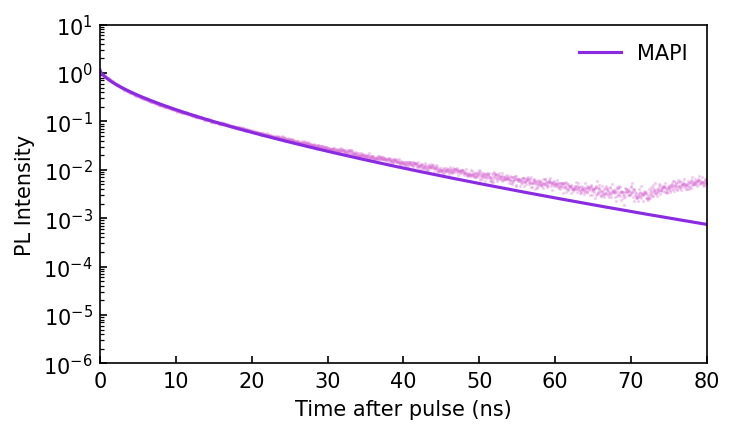

{'MAPI': 5.19}


In [51]:
################################
# Plotting
################################


fig, ax = plt.subplots(dpi=150, figsize=(5, 3))
fitcolors = ['blueviolet', 'royalblue', 'k']
datcolors = ['orchid', 'cadetblue', 'grey']

for i, df in enumerate(df_list):
    ax.plot(df['Time (ns)'], fits[i], color=fitcolors[i], label=labels[i])
    ax.scatter(df['Time (ns)'], df[labels[i]], color=datcolors[i], marker='o', alpha=0.3, s = 0.3)
 

ax.set_xlim(0,200)
ax.set_ylim(0.000001, 10)
ax.set_yscale('log')
ax.set_ylabel('PL Intensity')
ax.set_xlabel('Time after pulse (ns)')
ax.tick_params(direction='in', which='both')
ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.savefig(figure_folder + r'\fitted_plot_' + figure_suffix)
plt.show()

print(taus)
